---

# K-Nearest Neighbors Implementation on Iris Dataset

By: Laura Moses

---

## Definition
The **$K$-nearest neighbors algorithm** (KNN) is a simple supervised machine learning algorithm that makes no mathematical assumptions, but assumes only that points that are close to one another are similar. Thus, the  prediction for each new point depends only on the points in closest proximity to it.

---

### Uses
The KNN algorithm is commonly used for:
* Classification
* Regression
* Search

---

### Advantages
* The algorithm is one of the simplest and easy to implement
* There are no mathematical assumptions 
* There's no need to build a model or tune several parameters
* The algorithm is versatile (several uses)

---

### Disadvantages
* Sensitivity to high dimension feature vectors can significantly slow the algorithm

---


## KNN Method
1. Load the data
1. Initialize $k$ to your chosen number of neighbors
1. For each example in the data
    1. Calculate the distance between the query example and the current example from the data.
    1. Add the distance and the index of the example to an ordered collection
1. Sort the ordered collection of distances and indices from smallest to largest (in ascending order) by the distances 
1. Pick the first $K$ entries from the sorted collection
1. Get the labels of the selected $k$ entries
1. If regression, return the mean of the $K$ labels
1. If classification, return the mode of the $K$ labels

---

## Implementation

### Iris Dataset
This example uses the `iris` dataset from `RDatasets`. The data is loaded as a `DataFrame` with columns:
* `SepalLength`
* `SepalWidth`
* `PetalLength`
* `PetalWidth`
* `Species`

The task is to predict the species of an iris based on it's closest features of choice: sepal length, sepal width, and petal length. 

---

To access this data set and run this notebook, we will need the following packages:
* Rdatasets [documentation](https://github.com/JuliaStats/RDatasets.jl)
* Plots [documentation](http://docs.juliaplots.org/latest/)
* Random [documentationra](https://docs.julialang.org/en/v1/stdlib/Random/)

---

In [2]:
# Import Packages
using RDatasets
using Plots
theme(:default)
using CSV
using DataFrames
using Random

---

To begin, we load the iris dataset and store the `SepalLength`, `SepalWidth`, and `PetalLength` features and their corresponding `Species` labels.

---

In [3]:
# Load iris data
iris = dataset("datasets", "iris")

# load features and labels
x_data = [x for x in zip(iris.SepalLength, iris.SepalWidth, iris.PetalLength)]
y_data = [iris.Species[i] for i = 1:150];

---

### Checking Assumptions

In the context of this problem, the KNN assumes only that same species have sepal and petal features with close proximity. To visualize and inspect these featuers in 3-D space, we will plot the sepal length vs. sepal width vs. petal length, colored by species below:

---

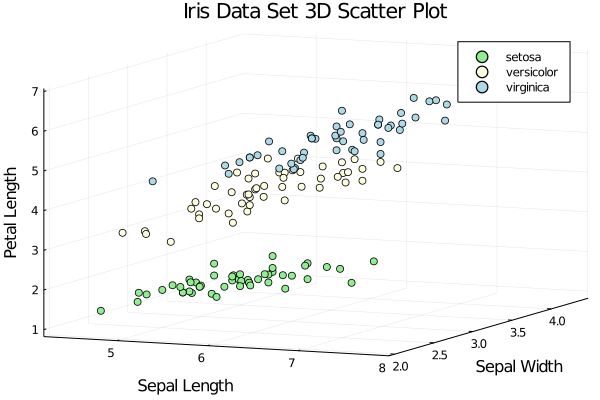

In [4]:
# Plot
scatter(xaxis = "Sepal Length",
        yaxis = "Sepal Width", 
        zaxis = "Petal Length",
        title = "Iris Data Set 3D Scatter Plot")
scatter!(x_data[1:50],
        label = "setosa",
        color = "lightgreen")
scatter!(x_data[51:100],
        label = "versicolor",
        color = "lightyellow")

scatter!(x_data[101:150],
        label = "virginica",
        color = "lightblue")

---

In the plot generated above, we can see that the iris species are, indeed, grouped together, satisfying the KNN algorithm assumption that similar points are close together. In order to predict a label, the KNN algorithm requires the calculation of distance between the points on the graph. 

To calculate distance, use the simple straight-line distance formula for Euclidiean distance, given by 

$$d(x^i, x^j) = \sqrt{\Sigma_{n=1}^l(x_n^i - x_n^j)^2}$$

The function which returns this distance in written below:

---

In [13]:
""" Given points p1 and p2, calculate the Euclidean distance
"""
function distance(p1, p2)
    return sqrt(sum([(p1[i] - p2[i])^2 for i = 1:length(p1)]))
end

# Test the distance function 
print("The distance between ", x_data[1]," and ", x_data[50])
println(" is ", distance(x_data[1], x_data[50]))

The distance between (5.1, 3.5, 1.4) and (5.0, 3.3, 1.4) is 0.22360679774997896


---

### Split Data
The data $D$ will first be randomly split into training and test sets based on a percentage of the dataset $p$ such that training data is $p\%$ of $D$ and test data is $(100-p)\%$ of $D$. 

The data will then be subdivided into points $X$ with labels $Y$ for each training and test set, i.e. $(X_{train}, Y_{train})$ and $(X_{test}, Y_{test})$.

---

In [5]:
""" Split data in a df into training and test fractions of train_prop and 1 - train_prop
"""
function split_data(df, train_prop = 0.7)
    n = nrow(df)
    index = shuffle(1:n)
    train_index = view(index, 1:floor(Int, train_prop*n))
    test_index = view(index, (floor(Int, train_prop*n)+1):n)
    
    return df[train_index,:], df[test_index,:]
end

# Test function
train, test = split_data(iris, 0.7)

In [11]:
"""
Split training and test data from a df into proportions train_pop and 1-train_prop, 
then subdivide training and test into features (x) and labels (y) using 
feat1, feat2, feat3 and label as column names in df. 
Returns x_train, y_train, x_test, y_test datasets. 
"""
function train_test_split(df, train_prop, feat1, feat2, feat3, label)
    # Split the data into training and test sets
    train, test = split_data(df, train_prop)
    
    # Separate train/test into features (x) and labels (y) sets
    x_train = [x for x in zip(train[1:nrow(train), feat1], train[1:nrow(train), feat2], train[1:nrow(train), feat3])]
    y_train = [train[i, label] for i = 1:nrow(train)]
    x_test  = [x for x in zip(test[1:nrow(test), feat1], test[1:nrow(test), feat2], test[1:nrow(test), feat3])]
    y_test  = [test[i, label] for i = 1:nrow(test)]
    
    # Return data sets
    return x_train, y_train, x_test, y_test
end

x_train, y_train, x_test, y_test = train_test_split(iris, 0.7, "SepalLength", "SepalWidth", "PetalLength", "Species");

---

### Compute $K$-Nearest Neighbors

Now that the data sets have been split into training and test functions, we will using our training data on our $K$-Nearest Neighbors prediction to see how well our predictions are. 

---

In [26]:
""" For a given point p, a collection of points X with labels Y, 
and a positive integer k, find the nearest neighbors to point p.
"""
function k_nearest_neighbors(p, X, Y, k)
    # Calculate the distance between p and all other points in X
    distance_array = [(X[i], Y[i], distance(p, X[i])) for i = 1:length(X)]
    
    # Sort the distance array in ascending order according to distance
    sort!(distance_array, by = x -> x[3])
    
    # Return the first k entries from the sorted distance array
    ## Since the first entry is p, itself, we use the next k entries*
    return distance_array[2:k+1]
end

k_nearest_neighbors

In [27]:
"""This is specific to the iris dataset, predicts by returning the majority of correct label
"""
function KNN_iris_predictor(p, X, Y, k)
    neighbors = k_nearest_neighbors(p, X, Y, k)
    
    # get counts for each label/classification
    setosa_count = [1.0 for x in neighbors if x[2] == "setosa"]
    versicolor_count = [1.0 for x in neighbors if x[2] == "versicolor"]
    virginica_count = [1.0 for x in neighbors if x[2] == "virginica"]
    
    # find the max/majority
    temp_list = [("setosa", setosa_count),("versicolor", versicolor_count),("virginica", virginica_count)]
    sort!(temp_list, by = x -> x[2])
    
    return temp_list[end][1]
end


KNN_iris_predictor

In [105]:
# Test the k_nearest_neighbors function
for i = 1:4
    k = rand(1:10)
    p = rand(1:length(x_train))
    println("The K-Nearest Neighbors to point ", x_train[p], " when K = ", k, " are:")
    k_nearest_neighbors(x_train[p], x_train, y_train, k)
    println("The true label at this point is: ", y_train[p])
    println("The predicted label at this point is: ", KNN_iris_predictor(x_train[p], x_train, y_train, k))
    println()
end

The K-Nearest Neighbors to point (5.3, 3.7, 1.5) when K = 8 are:
The true label at this point is: setosa
The predicted label at this point is: setosa

The K-Nearest Neighbors to point (6.3, 3.3, 4.7) when K = 8 are:
The true label at this point is: versicolor
The predicted label at this point is: versicolor

The K-Nearest Neighbors to point (7.9, 3.8, 6.4) when K = 6 are:
The true label at this point is: virginica
The predicted label at this point is: virginica

The K-Nearest Neighbors to point (4.5, 2.3, 1.3) when K = 3 are:
The true label at this point is: setosa
The predicted label at this point is: setosa



---

## Determining an Optimal $K$

We can see for at least four random point in our training set, the KNN algorithm correctly predicted the flower species for various values of $K$. To determine the accuracy/error rate of our predicted labels vs. true label, we will define an `accuracy` function below. This function will determine the accuracy percentage for all values in a dataset ($X$, $Y$) for a specified $K$. 

---

In [134]:
# Percentage of correct predictions based on classification error
function accuracy(X, Y, k)
    correct = 0
    for p = 1:length(X)
        if KNN_iris_predictor(X[p], X, Y, k) == Y[p]
            correct += 1
        end
    end
    acc = (correct / length(X))*100
    return round(acc, digits = 2)
end;

In [130]:
# This function returns the optimal K corresponding to the maximum accuracy rate, 
## testing K values 1:k_test, and an array of points (tested K values, correspdoning accuracy rates) 
## for plotting purposes

function best_acc_k(X, Y, k_test=10)
    
    # Initialize empty accuracy array to store accuracy% and corresponding K
    acc_array = []
    k_array = []
    
    # Store accuracy, k
    for k = 1:k_test
        push!(acc_array, accuracy(X, Y, k))
        push!(k_array, k)
    end
    
    # Zip data
    data = [x for x in zip(k_array, acc_array)]
    
    # Determine optimal K and maximum accuracy
    best_k = findmax(acc_array)[2]
    best_acc = maximum(acc_array)
    
    return best_k, best_acc, data
end;

In [131]:
best_k, best_acc, data = best_acc_k(x_train, y_train);

In [132]:
println("Our best percent accuracy from the training data was ", best_acc, "% using K = ", best_k)

Our best percent accuracy from the training data was 94.29% using K = 8


---

Our results from the training data gave us an optimal $K$ value of $8$, with a $94.29\%$ accuracy rate. The plot below shows how the accuracy varied with different $K$ values.  

---

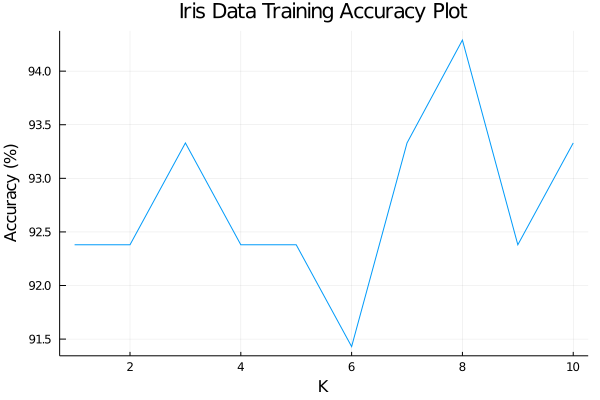

In [133]:
# Plot Accuracy Results
plot(xaxis = "K",
    yaxis = "Accuracy (%)", 
    title = "Iris Data Training Accuracy Plot")
plot!([p for p in data], 
     label = false)

---

## Conclusion

Using our trained best $K$, we will now test our KNN prediction accuracy on our test data set to determine the accuracy and error rate when $K=8$. 


In [138]:
println("The accuracy on the test data is ", accuracy(x_test, y_test, 8), "%, with an error rate of ",
    round(100 - accuracy(x_test, y_test, 8), digits = 2), "%, for the optimal K = 8")

The accuracy on the test data is 97.78%, with an error rate of 2.22%, for the optimal K = 8


Thus, training our data using features of Sepal Length, Sepal Width, and Petal Length, we found the optimal $K$ value for using $K$-Nearest Neighbors was $8$, resulting in a $97.78\%$ accuracy (an error rate of $2.22\%$ ). 

---